# Agile Modeling for Bioacoustics.

This notebook provides a workflow for creating custom classifiers for target signals, by first **searching** for training data, and then engaging in an **active learning** loop.

We assume that embeddings have been pre-computed using `embed.ipynb`.

## Configuration and Imports.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import collections
from etils import epath
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from chirp.inference import colab_utils
from perch_hoplite.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
from perch_hoplite.zoo import zoo_interface

In [2]:
# Working dir for saving products
working_dir = "/workspaces/2023_ECCC4_Biodiv/data/"
embeddings_path = working_dir + "embeddings"
custom_classifier_path = epath.Path(working_dir) / "custom_classifier"
plot_path = "/workspaces/2023_ECCC4_Biodiv/data/plots"
os.makedirs(plot_path, exist_ok=True)

# Label path
# It will identify all the folders with species audio data in
# The folder names need to match the species name, as it 
# is used as the class label.
# If only one species folder present, then only one class will be used
labeled_data_path = epath.Path(working_dir) / "labels_top_large"

In [3]:
# Load model state
if (embeddings_path or (epath.Path(working_dir) / 'embeddings/config.json').exists()):
  if not embeddings_path:
    # Use the default embeddings path, as it seems we found a config there.
    embeddings_path = epath.Path(working_dir) / 'embeddings'
  # Get relevant info from the embedding configuration.
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,annotated_path=labeled_data_path)
else:
  raise ValueError('No embedding configuration found.')

project_state = bootstrap.BootstrapState(
    bootstrap_config, baw_auth_token='')

## Embed labeled data

In [4]:
# Load+Embed the Labeled Dataset
merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=labeled_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling='mean',
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
lbl_counts = np.sum(merged.data['label_hot'], axis=0)
print('num classes :', (lbl_counts > 0).sum())
print('mean ex / class :', lbl_counts.sum() / (lbl_counts > 0).sum())
print('min ex / class :', (lbl_counts + (lbl_counts == 0) * 1e6).min())

Embedding from Folder of Folders...
Checking for existing embeddings from Folder of Folders...
Found 0 existing embeddings.
Checking for new sources to embed from Folder of Folders...


0it [00:00, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1742402102.879848    2176 service.cc:145] XLA service 0x56465d5962f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742402102.879899    2176 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
W0000 00:00:1742402103.128559    2176 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1742402109.024791    2176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
500it [00:12, 40.34it/s] 
500it [00:05, 99.46it/s] 
500it [00:10, 49.95it/s] 
500it [00:05, 98.95it/s] 
500it [00:06, 81.91it/s] 
500it [00:05, 99.08it/s] 
500it [00:04, 105.10it/s]
500it [00:04, 106.64it/s]
500it [00:08, 60.96it/s] 
500it [00:04, 105.09it/s]
500it [00:04, 107.39it/s]
5


...embedded dataset in 245.37s...
    found 44 classes.
    class Anas platyrhynchos / 0 : 500
    class Branta canadensis / 1 : 500
    class Cardinalis cardinalis / 2 : 500
    class Catharus fuscescens / 3 : 500
    class Certhia americana / 4 : 500
    class Colaptes auratus / 5 : 500
    class Contopus virens / 6 : 500
    class Corthylio calendula / 7 : 500
    class Corvus corax / 8 : 500
    class Cyanocitta cristata / 9 : 500
    class Dryobates pubescens / 10 : 500
    class Dryobates villosus / 11 : 500
    class Dryocopus pileatus / 12 : 500
    class Dumetella carolinensis / 13 : 500
    class Empidonax alnorum / 14 : 500
    class Empidonax minimus / 15 : 500
    class Geothlypis trichas / 16 : 500
    class Hylocichla mustelina / 17 : 500
    class Icterus galbula / 18 : 433
    class Junco hyemalis / 19 : 500
    class Larus delawarensis / 20 : 474
    class Melospiza georgiana / 21 : 500
    class Melospiza melodia / 22 : 500
    class Mniotilta varia / 23 : 500
    c

## Train classifier using embeded labels

In [5]:
# Train small model over embeddings

# Number of random training examples to choose form each class.
# Set exactly one of `train_ratio` and `train_examples_per_class`.
# Adjust `train_ratio` if dataset is smaller than 9 observations
# Otherwise you will get error: "IndexError: arrays used as indices must be of integer (or boolean) type"
train_ratio = 0.8
train_examples_per_class = None

# Number of random re-trainings. Allows judging model stability.
num_seeds = 3

# Classifier training hyperparams.
# These should be good defaults.
batch_size = 16          # 32
num_epochs = 128         # 128
num_hiddens = -1          # -1
batch_norm = False
learning_rate = 1e-3

metrics = collections.defaultdict(list)
for seed in tqdm.tqdm(range(num_seeds)):
  if num_hiddens > 0:
    model = classify.get_two_layer_model(
        num_hiddens,
        merged.embedding_dim,
        merged.num_classes,
        batch_norm=batch_norm)
  else:
    model = classify.get_linear_model(
        merged.embedding_dim,
        merged.num_classes)
  run_metrics = classify.train_embedding_model(
      model,
      merged,
      train_ratio,
      train_examples_per_class,
      num_epochs,
      seed,
      batch_size,
      learning_rate)
  metrics['acc'].append(run_metrics.top1_accuracy)
  metrics['auc_roc'].append(run_metrics.auc_roc)
  metrics['cmap'].append(run_metrics.cmap_value)
  metrics['maps'].append(run_metrics.class_maps)
  metrics['test_logits'].append(run_metrics.test_logits)

mean_acc = np.mean(metrics['acc'])
mean_auc = np.mean(metrics['auc_roc'])
mean_cmap = np.mean(metrics['cmap'])

# Merge the test_logits into a single array.
test_logits = {
    k: np.concatenate([logits[k] for logits in metrics['test_logits']])
    for k in metrics['test_logits'][0].keys()
}

print(f'acc:{mean_acc:5.2f}, auc_roc:{mean_auc:5.2f}, cmap:{mean_cmap:5.2f}')
for lbl, auc in zip(merged.labels, run_metrics.class_maps):
  if np.isnan(auc):
    continue
  print(f'\n{lbl:8s}, auc_roc:{auc:5.2f}')
  colab_utils.prstats(f'test_logits({lbl})',
                      test_logits[merged.labels.index(lbl)])

100%|██████████| 3/3 [20:10<00:00, 403.63s/it]


acc: 0.99, auc_roc: 1.00, cmap: 1.00

Anas platyrhynchos, auc_roc: 1.00
test_logits(Anas platyrhynchos) : 	shape:           (300,)	min:  -8.01	mean:  17.42	max:  33.47	std:   8.13

Branta canadensis, auc_roc: 1.00
test_logits(Branta canadensis) : 	shape:           (300,)	min:   1.36	mean:  17.34	max:  26.17	std:   4.67

Cardinalis cardinalis, auc_roc: 1.00
test_logits(Cardinalis cardinalis) : 	shape:           (300,)	min:  -2.38	mean:  16.07	max:  25.53	std:   4.53

Catharus fuscescens, auc_roc: 1.00
test_logits(Catharus fuscescens) : 	shape:           (300,)	min:  -4.83	mean:  18.27	max:  33.33	std:   6.47

Certhia americana, auc_roc: 1.00
test_logits(Certhia americana) : 	shape:           (300,)	min:  -6.69	mean:  11.76	max:  25.74	std:   5.64

Colaptes auratus, auc_roc: 1.00
test_logits(Colaptes auratus) : 	shape:           (300,)	min:  -4.87	mean:  15.59	max:  24.90	std:   5.52

Contopus virens, auc_roc: 1.00
test_logits(Contopus virens) : 	shape:           (300,)	min:   5.10	mean:

## Test classifier on unlabeled embedded data

263929it [02:00, 2188.13it/s]


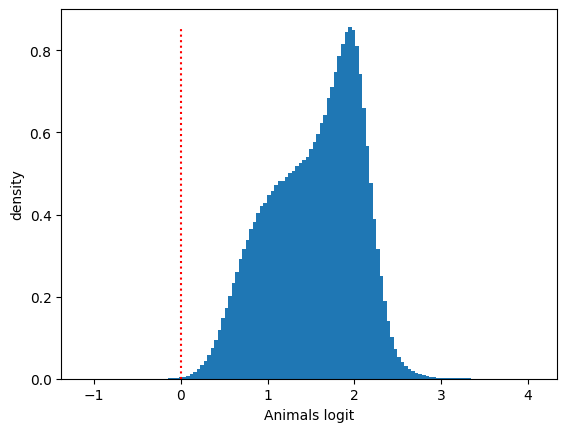

In [11]:
# Run model on target unlabeled data.

# Specify target class for testing
target_class = "Animals"

# Choose a target logit; will display results close to the target.
# Set to None to get the highest-logit examples.
target_logit = 0.0

# Number of results to display.
num_results = 50

embeddings_ds = project_state.create_embeddings_dataset(
    shuffle_files=True)

target_class_idx = merged.labels.index(target_class)

results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    target_score=target_logit,
    top_k=num_results
)

# Plot the histogram of logits.
ys, _, _ = plt.hist(all_logits, bins=128, density=True)
plt.xlabel(f'{target_class} logit')
plt.ylabel('density')
plt.plot([target_logit, target_logit], [0.0, np.max(ys)], 'r:')

# Save plot
plot_path_name = plot_path + "/" + target_class + "_histogram_logits.png"
plt.savefig(plot_path_name)

# View
plt.show()

## Save model

In [6]:
# Save the Custom Classifier.
wrapped_model = zoo_interface.LogitsOutputHead(
    model_path=custom_classifier_path.as_posix(),
    logits_key='logits',
    logits_model=model,
    class_list=namespace.ClassList('custom', merged.labels),
)
wrapped_model.save_model(
    custom_classifier_path,
    embeddings_path)

INFO:tensorflow:Assets written to: /workspaces/2023_ECCC4_Biodiv/data/custom_classifier/assets


INFO:tensorflow:Assets written to: /workspaces/2023_ECCC4_Biodiv/data/custom_classifier/assets
